In this Jupyter notebook, we will explore the possibility to forecast the price of a stock at time t, based on some linear regressions of previous prices (of both the stock and the rest of the market).  

In [86]:
import pandas as pd
import numpy as np
import scipy 
import statsmodels.api as sm
import sklearn
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import random
from scipy.stats import norm
import pmdarima as pm

In [65]:
dataset=pd.read_parquet('/Users/emanueledurante/Desktop/LGMB/lausanne/epfl/MLfinance/High-Frequency-Trading-with-Deep-Learning/data/high_10m.parquet')

In [66]:
dataset.describe()
symbols_with_enough_data = dataset['SYMBOL'].value_counts()
symbols_over_60 = symbols_with_enough_data[symbols_with_enough_data > 60].index
dataset = dataset[dataset['SYMBOL'].isin(symbols_over_60)]
dataset=dataset[dataset['RETURN']!=0]

In [67]:
dataset.head()

DATE SYMBOL      TIME            ALL_EX  MID_OPEN  SUM_DELTA    RETURN
1 2021-12-01      A  09:40:00   PBTJVDZUYKNHCXM   150.490   0.473357 -0.011170
2 2021-12-01      A  09:50:00    KDPBTJVNZUCXYH   151.475 -10.867709  0.006545
3 2021-12-01      A  10:00:00   DABTJNKYVPZUXCH   150.510  -0.125414 -0.006371
4 2021-12-01      A  10:10:00  DVJTPNKUZYACBXHM   151.960  -1.274648  0.009634
5 2021-12-01      A  10:20:00  DPCNZUKYTJVHBMAX   151.790  -2.211760 -0.001119

In [72]:

def rolling_regression_single_symbol_fit_over_50(df: pd.DataFrame, symbol: str, PLOT__: bool = True) -> tuple[float, float, tuple[float, float], str]:
    '''
    Perform rolling linear regressions using scikit-learn.
    Each model is trained on 50 observations with 10 lagged returns as features,
    and used to predict the next return. Each model is used to predict exactly one future return.

    Inputs:
        df (pd.DataFrame): contains ['SYMBOL', 'DATE', 'TIME', 'RETURN']
        symbol (str): the symbol to process
        PLOT__ (bool): if True, shows scatterplot of actual vs predicted

    Outputs:
        r2 (float): R² score
        sign_accuracy (float): percentage of correctly predicted signs
        ci (tuple): 99% confidence interval around sign accuracy
        significant (str): 'YES' if interval excludes 0.5, otherwise 'NO'
    '''
    group = df[df['SYMBOL'] == symbol].sort_values(by=['DATE', 'TIME']).reset_index(drop=True)
    returns = group['RETURN'].values

    max_lag = 10
    train_size = 50
    min_required = train_size + max_lag

    if len(returns) < min_required + 1:
        return np.nan, np.nan, (np.nan, np.nan), 'NA'

    # Build lag matrix and targets
    X_lags = np.column_stack([returns[i:len(returns)-max_lag+i] for i in range(max_lag)])
    y_all = returns[max_lag:]

    y_true = []
    y_pred = []

    max_t = len(y_all) - train_size - 1

    for t in range(max_t):
        X_train = X_lags[t:t+train_size]
        y_train = y_all[t:t+train_size]

        model = LinearRegression()
        model.fit(X_train, y_train)

        x_test = X_lags[t + train_size].reshape(1, -1)
        pred = model.predict(x_test)[0]

        y_true.append(y_all[t + train_size])
        y_pred.append(pred)

    if not y_true:
        return np.nan, np.nan, (np.nan, np.nan), 'NA'

    r2 = r2_score(y_true, y_pred)
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    sign_accuracy = np.mean(np.sign(y_true) == np.sign(y_pred))

    # Confidence interval (99%)
    n = len(y_true)
    p_hat = sign_accuracy
    p_0 = 0.5
    z = norm.ppf(1 - 0.01 / 2)  # two-tailed 99% → z ≈ 2.576
    se = np.sqrt(p_0 * (1 - p_0) / n)
    margin = z * se
    ci_low = p_hat - margin
    ci_high = p_hat + margin
    significant = "YES" if ci_low > 0.5 or ci_high < 0.5 else "NO"
    if PLOT__:
        plt.figure(figsize=(6, 6))
        plt.scatter(y_true, y_pred, alpha=0.6)
        plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], color='red', linestyle='--')
        plt.xlabel('Actual RETURN')
        plt.ylabel('Predicted RETURN')
        plt.title(f'{symbol}\nR² = {r2:.4f}, Sign Accuracy = {sign_accuracy:.2%}')
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    return r2, sign_accuracy, (ci_low, ci_high), significant


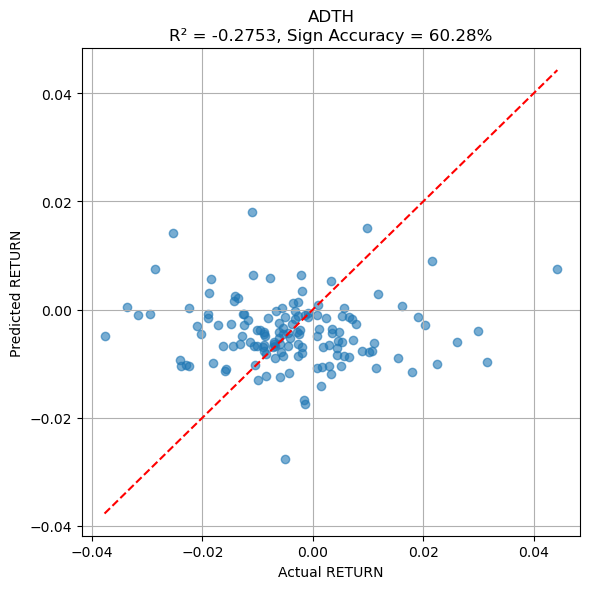

(-0.27525703831310255,
 0.6028368794326241,
 (0.4943748996164671, 0.7112988592487811),
 'NO')

In [73]:
rolling_regression_single_symbol_fit_over_50(dataset,'ADTH')

In [ ]:
symbols = dataset['SYMBOL'].dropna().unique()
random_symbols = random.sample(list(symbols), k=100)
for symbol in random_symbols:
    r2, sign_acc,_,significant = rolling_regression_single_symbol_fit_over_50(dataset, symbol,False)
    print(f'{symbol}: R² = {r2:.4f}, Sign Accuracy = {sign_acc:.2%},Significance={significant}')

YCBD — R²: -0.3592 | Sign Accuracy: 50.61% (99% CI: [43.50%, 57.72%]) → Significant: NO
YCBD: R² = -0.3592, Sign Accuracy = 50.61%
SAH — R²: -0.4254 | Sign Accuracy: 51.29% (99% CI: [46.54%, 56.03%]) → Significant: NO
SAH: R² = -0.4254, Sign Accuracy = 51.29%
PTLC — R²: -0.2709 | Sign Accuracy: 52.10% (99% CI: [47.20%, 57.01%]) → Significant: NO
PTLC: R² = -0.2709, Sign Accuracy = 52.10%
PWS — R²: -0.3718 | Sign Accuracy: 50.00% (99% CI: [42.28%, 57.72%]) → Significant: NO
PWS: R² = -0.3718, Sign Accuracy = 50.00%
EMCF — R²: 0.1253 | Sign Accuracy: 52.00% (99% CI: [26.24%, 77.76%]) → Significant: NO
EMCF: R² = 0.1253, Sign Accuracy = 52.00%
EAI — R²: -0.2139 | Sign Accuracy: 56.83% (99% CI: [49.11%, 64.56%]) → Significant: NO
EAI: R² = -0.2139, Sign Accuracy = 56.83%
NU — R²: -0.3944 | Sign Accuracy: 49.88% (99% CI: [43.56%, 56.20%]) → Significant: NO
NU: R² = -0.3944, Sign Accuracy = 49.88%
NVEE — R²: -0.3018 | Sign Accuracy: 49.12% (99% CI: [44.37%, 53.87%]) → Significant: NO
NVEE: R

In [78]:
def rolling_ridge_single_symbol_fit_over_50(df: pd.DataFrame, symbol: str, alpha: float=10e-1,PLOT__: bool = True) -> tuple[float, float, tuple[float, float], str]:
    '''
    Perform rolling ridge regressions using scikit-learn.
    Each model is trained on 50 observations with 10 lagged returns as features,
    and used to predict the next return. Each model is used to predict exactly one future return.

    Inputs:
        df (pd.DataFrame): contains ['SYMBOL', 'DATE', 'TIME', 'RETURN']
        symbol (str): the symbol to process
        PLOT__ (bool): if True, shows scatterplot of actual vs predicted

    Outputs:
        r2 (float): R² score
        sign_accuracy (float): percentage of correctly predicted signs
        ci (tuple): 99% confidence interval around sign accuracy
        significant (str): 'YES' if interval excludes 0.5, otherwise 'NO'
    '''
    group = df[df['SYMBOL'] == symbol].sort_values(by=['DATE', 'TIME']).reset_index(drop=True)
    returns = group['RETURN'].values

    max_lag = 10
    train_size = 50
    min_required = train_size + max_lag

    if len(returns) < min_required + 1:
        return np.nan, np.nan, (np.nan, np.nan), 'NA'

    # Build lag matrix and targets
    X_lags = np.column_stack([returns[i:len(returns)-max_lag+i] for i in range(max_lag)])
    y_all = returns[max_lag:]

    y_true = []
    y_pred = []

    max_t = len(y_all) - train_size - 1

    for t in range(max_t):
        X_train = X_lags[t:t+train_size]
        y_train = y_all[t:t+train_size]

        model = Ridge(alpha)
        model.fit(X_train, y_train)

        x_test = X_lags[t + train_size].reshape(1, -1)
        pred = model.predict(x_test)[0]

        y_true.append(y_all[t + train_size])
        y_pred.append(pred)

    if not y_true:
        return np.nan, np.nan, (np.nan, np.nan), 'NA'

    r2 = r2_score(y_true, y_pred)
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    sign_accuracy = np.mean(np.sign(y_true) == np.sign(y_pred))

    # Confidence interval (99%)
    n = len(y_true)
    p_hat = sign_accuracy
    p_0 = 0.5
    z = norm.ppf(1 - 0.01 / 2)  # two-tailed 99% → z ≈ 2.576
    se = np.sqrt(p_0 * (1 - p_0) / n)
    margin = z * se
    ci_low = p_hat - margin
    ci_high = p_hat + margin
    significant = "YES" if ci_low > 0.5 or ci_high < 0.5 else "NO"
    if PLOT__:
        plt.figure(figsize=(6, 6))
        plt.scatter(y_true, y_pred, alpha=0.6)
        plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], color='red', linestyle='--')
        plt.xlabel('Actual RETURN')
        plt.ylabel('Predicted RETURN')
        plt.title(f'{symbol}\nR² = {r2:.4f}, Sign Accuracy = {sign_accuracy:.2%}')
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    return r2, sign_accuracy, (ci_low, ci_high), significant

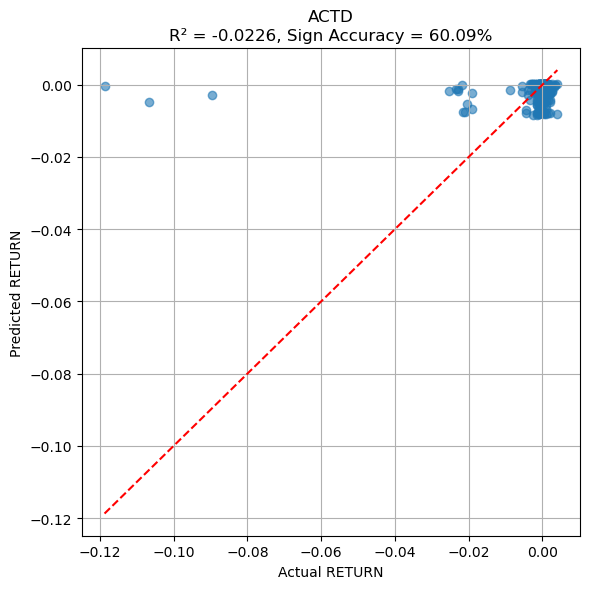

(-0.022641808029389754,
 0.6009174311926605,
 (0.51368884426545, 0.688146018119871),
 'YES')

In [81]:
rolling_ridge_single_symbol_fit_over_50(dataset,'ACTD')

In [80]:
symbols = dataset['SYMBOL'].dropna().unique()
random_symbols = random.sample(list(symbols), k=100)
for symbol in random_symbols:
    r2, sign_acc,_,significant = rolling_ridge_single_symbol_fit_over_50(dataset, symbol,PLOT__=False)
    print(f'{symbol}: R² = {r2:.4f}, Sign Accuracy = {sign_acc:.2%},Significance={significant}')

BMY: R² = -0.0186, Sign Accuracy = 49.03%,Significance=NO
GSLD: R² = -0.0310, Sign Accuracy = 51.72%,Significance=NO
ETG: R² = -0.0150, Sign Accuracy = 52.11%,Significance=NO
GBLI: R² = -0.0154, Sign Accuracy = 57.00%,Significance=NO
OPTT: R² = -0.0328, Sign Accuracy = 51.95%,Significance=NO
IBMK: R² = -0.0330, Sign Accuracy = 40.74%,Significance=NO
ACTD: R² = -0.0226, Sign Accuracy = 60.09%,Significance=YES
WTM: R² = -0.0310, Sign Accuracy = 52.54%,Significance=NO
GNOM: R² = -0.0238, Sign Accuracy = 50.00%,Significance=NO
ECNS: R² = -0.0303, Sign Accuracy = 49.70%,Significance=NO
INTG: R² = -0.0473, Sign Accuracy = 50.00%,Significance=NO
CMU: R² = -0.0559, Sign Accuracy = 47.32%,Significance=NO
LEDS: R² = -0.0219, Sign Accuracy = 47.54%,Significance=NO
SELF: R² = -0.0113, Sign Accuracy = 56.47%,Significance=NO
FLAC: R² = nan, Sign Accuracy = nan%,Significance=NA
VFL: R² = -0.0236, Sign Accuracy = 26.67%,Significance=YES
IBB: R² = -0.0166, Sign Accuracy = 50.40%,Significance=NO
EVGO: R

/Users/emanueledurante/anaconda3/envs/MLfinanceHW2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


HRC: R² = -0.0333, Sign Accuracy = 47.02%,Significance=NO
DSPG: R² = nan, Sign Accuracy = nan%,Significance=NA
IETC: R² = -0.0176, Sign Accuracy = 49.31%,Significance=NO
PSQ: R² = -0.0213, Sign Accuracy = 49.32%,Significance=NO
LINC: R² = -0.0224, Sign Accuracy = 50.00%,Significance=NO
QTNT: R² = -0.0249, Sign Accuracy = 48.82%,Significance=NO
SUMO: R² = -0.0190, Sign Accuracy = 49.73%,Significance=NO
LGI: R² = -0.0195, Sign Accuracy = 56.57%,Significance=YES
LBRT: R² = -0.0281, Sign Accuracy = 48.36%,Significance=NO
BTCR: R² = -0.0108, Sign Accuracy = 54.70%,Significance=NO
OSW: R² = -0.0099, Sign Accuracy = 51.62%,Significance=NO
DYNF: R² = -0.0180, Sign Accuracy = 54.25%,Significance=NO
EFAV: R² = -0.0186, Sign Accuracy = 50.52%,Significance=NO
DBP: R² = -0.0353, Sign Accuracy = 52.69%,Significance=NO
TROW: R² = -0.0160, Sign Accuracy = 48.53%,Significance=NO
SOR: R² = -0.0194, Sign Accuracy = 47.44%,Significance=NO
FIVE: R² = -0.0277, Sign Accuracy = 47.07%,Significance=NO
CMPS: R²

It seems like we are doing bettere then a fair coin toss but it is important to consider that if we are forecasting with a constant value (for example aleways positive) and indeed most of the time the stock is going up, we will have a good accuracy. Of course, this is not a good model, but it is important to consider that the accuracy of a model is not the only metric to evaluate its performance. We will also look at the sharpe of the strategy built out of the model.

In [82]:
def rolling_lasso_single_symbol_fit_over_50(df: pd.DataFrame, symbol: str, alpha: float=10e-1,PLOT__: bool = True) -> tuple[float, float, tuple[float, float], str]:
    '''
    Perform rolling lasso regressions using scikit-learn.
    Each model is trained on 50 observations with 10 lagged returns as features,
    and used to predict the next return. Each model is used to predict exactly one future return.

    Inputs:
        df (pd.DataFrame): contains ['SYMBOL', 'DATE', 'TIME', 'RETURN']
        symbol (str): the symbol to process
        PLOT__ (bool): if True, shows scatterplot of actual vs predicted

    Outputs:
        r2 (float): R² score
        sign_accuracy (float): percentage of correctly predicted signs
        ci (tuple): 99% confidence interval around sign accuracy
        significant (str): 'YES' if interval excludes 0.5, otherwise 'NO'
    '''
    group = df[df['SYMBOL'] == symbol].sort_values(by=['DATE', 'TIME']).reset_index(drop=True)
    returns = group['RETURN'].values

    max_lag = 10
    train_size = 50
    min_required = train_size + max_lag

    if len(returns) < min_required + 1:
        return np.nan, np.nan, (np.nan, np.nan), 'NA'

    # Build lag matrix and targets
    X_lags = np.column_stack([returns[i:len(returns)-max_lag+i] for i in range(max_lag)])
    y_all = returns[max_lag:]

    y_true = []
    y_pred = []

    max_t = len(y_all) - train_size - 1

    for t in range(max_t):
        X_train = X_lags[t:t+train_size]
        y_train = y_all[t:t+train_size]

        model = Lasso(alpha)
        model.fit(X_train, y_train)

        x_test = X_lags[t + train_size].reshape(1, -1)
        pred = model.predict(x_test)[0]

        y_true.append(y_all[t + train_size])
        y_pred.append(pred)

    if not y_true:
        return np.nan, np.nan, (np.nan, np.nan), 'NA'

    r2 = r2_score(y_true, y_pred)
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    sign_accuracy = np.mean(np.sign(y_true) == np.sign(y_pred))

    # Confidence interval (99%)
    n = len(y_true)
    p_hat = sign_accuracy
    p_0 = 0.5
    z = norm.ppf(1 - 0.01 / 2)  # two-tailed 99% → z ≈ 2.576
    se = np.sqrt(p_0 * (1 - p_0) / n)
    margin = z * se
    ci_low = p_hat - margin
    ci_high = p_hat + margin
    significant = "YES" if ci_low > 0.5 or ci_high < 0.5 else "NO"
    if PLOT__:
        plt.figure(figsize=(6, 6))
        plt.scatter(y_true, y_pred, alpha=0.6)
        plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], color='red', linestyle='--')
        plt.xlabel('Actual RETURN')
        plt.ylabel('Predicted RETURN')
        plt.title(f'{symbol}\nR² = {r2:.4f}, Sign Accuracy = {sign_accuracy:.2%}')
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    return r2, sign_accuracy, (ci_low, ci_high), significant

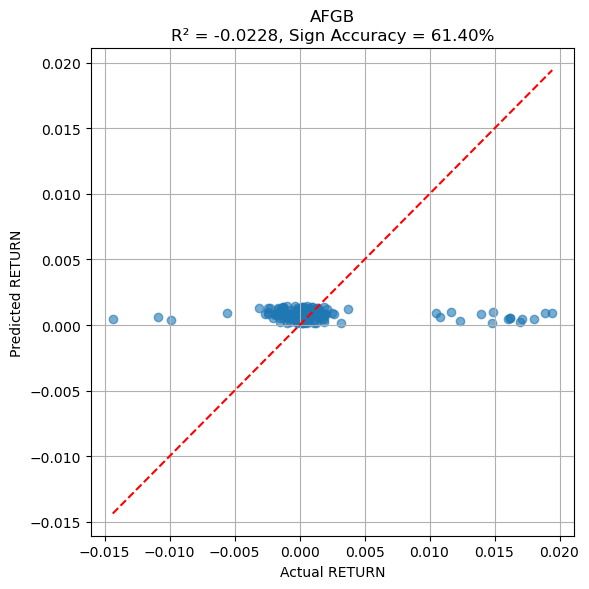

(-0.022780307868390137,
 0.6140350877192983,
 (0.5287408562486273, 0.6993293191899692),
 'YES')

In [85]:
rolling_lasso_single_symbol_fit_over_50(dataset,'AFGB')

In [84]:
symbols = dataset['SYMBOL'].dropna().unique()
random_symbols = random.sample(list(symbols), k=100)
for symbol in random_symbols:
    r2, sign_acc,_,significant = rolling_lasso_single_symbol_fit_over_50(dataset, symbol,PLOT__=False)
    print(f'{symbol}: R² = {r2:.4f}, Sign Accuracy = {sign_acc:.2%},Significance={significant}')

BTEK: R² = -0.0378, Sign Accuracy = 50.87%,Significance=NO
AZZ: R² = -0.0233, Sign Accuracy = 50.00%,Significance=NO
MTCR: R² = -0.0199, Sign Accuracy = 51.21%,Significance=NO
DXLG: R² = -0.0257, Sign Accuracy = 52.12%,Significance=NO
WATT: R² = -0.0249, Sign Accuracy = 50.17%,Significance=NO
SIZE: R² = -0.0287, Sign Accuracy = 52.30%,Significance=NO
ETJ: R² = -0.0170, Sign Accuracy = 49.65%,Significance=NO
GGG: R² = -0.0257, Sign Accuracy = 49.12%,Significance=NO
APGB: R² = -0.1588, Sign Accuracy = 64.29%,Significance=NO
VEEV: R² = -0.0268, Sign Accuracy = 48.07%,Significance=NO
SSTK: R² = -0.0256, Sign Accuracy = 50.61%,Significance=NO
CPUH: R² = -0.0218, Sign Accuracy = 62.50%,Significance=NO
ENS: R² = -0.0229, Sign Accuracy = 49.33%,Significance=NO
CSWI: R² = -0.0248, Sign Accuracy = 47.91%,Significance=NO
BSKY: R² = nan, Sign Accuracy = nan%,Significance=NA
HYGV: R² = -0.0170, Sign Accuracy = 54.14%,Significance=NO
CRUS: R² = -0.0178, Sign Accuracy = 51.14%,Significance=NO
ASRV: R

In [92]:
def rolling_arima_single_symbol_fit_over_50(df: pd.DataFrame, symbol: str, PLOT__: bool = True) -> tuple[float, float, tuple[float, float], str]:
    '''
    Perform rolling autoregressive forecasting using pmdarima's auto_arima.
    Each model is trained on 50 observations of raw returns and used to predict the next.
    Performance is measured by R² and sign accuracy, with 99% CI for the latter.

    Inputs:
        df (pd.DataFrame): must contain ['SYMBOL', 'DATE', 'TIME', 'RETURN']
        symbol (str): asset to analyze
        PLOT__ (bool): if True, shows scatterplot

    Outputs:
        r2 (float): R² score
        sign_accuracy (float): percent correct sign predictions
        ci (tuple): 99% confidence interval for sign accuracy
        significant (str): whether the sign accuracy is statistically different from 50%
    '''
    group = df[df['SYMBOL'] == symbol].sort_values(by=['DATE', 'TIME']).reset_index(drop=True)
    returns = group['RETURN'].values

    train_size = 50
    if len(returns) < train_size + 1:
        return np.nan, np.nan, (np.nan, np.nan), 'NA'

    y_true = []
    y_pred = []

    for t in range(len(returns) - train_size - 1):
        y_train = returns[t:t+train_size]

        try:
            model = pm.auto_arima(
                y_train,
                start_p=1, max_p=10,
                d=0,      # no differencing
                start_q=0, max_q=0,  # pure AR
                seasonal=False,
                stepwise=True,
                suppress_warnings=True,
                error_action='ignore'
            )

            forecast = model.predict(n_periods=1)[0]
            actual = returns[t + train_size]
            y_pred.append(forecast)
            y_true.append(actual)

        except Exception as e:
            continue

    if not y_true:
        return np.nan, np.nan, (np.nan, np.nan), 'NA'

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    r2 = r2_score(y_true, y_pred)
    sign_accuracy = np.mean(np.sign(y_true) == np.sign(y_pred))

    # Confidence interval
    n = len(y_true)
    p_hat = sign_accuracy
    p_0 = 0.5
    z = norm.ppf(1 - 0.01 / 2)
    se = np.sqrt(p_0 * (1 - p_0) / n)
    margin = z * se
    ci_low = p_hat - margin
    ci_high = p_hat + margin
    significant = "YES" if ci_low > 0.5 or ci_high < 0.5 else "NO"
    if PLOT__:
        plt.figure(figsize=(6, 6))
        plt.scatter(y_true, y_pred, alpha=0.6)
        plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], color='red', linestyle='--')
        plt.xlabel('Actual RETURN')
        plt.ylabel('Predicted RETURN')
        plt.title(f'{symbol}\nR² = {r2:.4f}, Sign Accuracy = {sign_accuracy:.2%}')
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    return r2, sign_accuracy, (ci_low, ci_high), significant


/Users/emanueledurante/anaconda3/envs/MLfinanceHW2/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/emanueledurante/anaconda3/envs/MLfinanceHW2/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/emanueledurante/anaconda3/envs/MLfinanceHW2/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/emanueledurante/anaconda3/envs/MLfinanceHW2/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/emanueledurante/anaconda3/envs/MLfinanceHW2/lib/python3.9

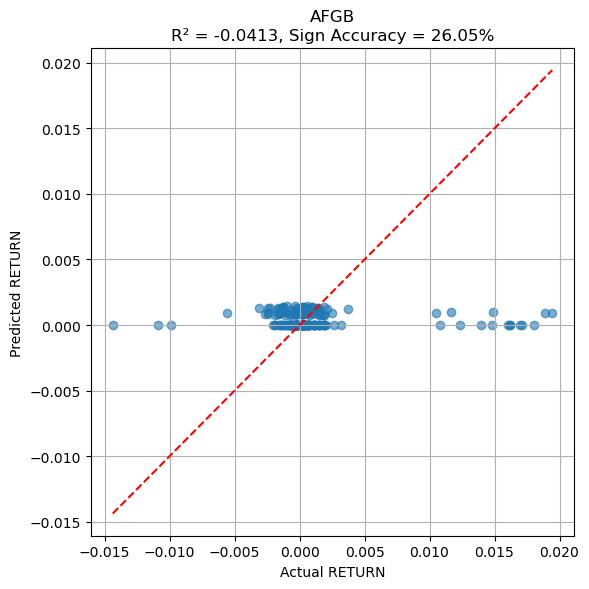

(-0.041292145821838266,
 0.2605042016806723,
 (0.1770210943909135, 0.34398730897043106),
 'YES')

In [91]:
rolling_arima_single_symbol_fit_over_50(dataset,'AFGB')

In [93]:
symbols = dataset['SYMBOL'].dropna().unique()
random_symbols = random.sample(list(symbols), k=10)
for symbol in random_symbols:
    r2, sign_acc,_,significant = rolling_arima_single_symbol_fit_over_50(dataset, symbol,PLOT__=False)
    print(f'{symbol}: R² = {r2:.4f}, Sign Accuracy = {sign_acc:.2%},Significance={significant}')

/Users/emanueledurante/anaconda3/envs/MLfinanceHW2/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/emanueledurante/anaconda3/envs/MLfinanceHW2/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/emanueledurante/anaconda3/envs/MLfinanceHW2/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/emanueledurante/anaconda3/envs/MLfinanceHW2/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/emanueledurante/anaconda3/envs/MLfinanceHW2/lib/python3.9

GHC: R² = -0.0303, Sign Accuracy = 15.70%,Significance=YES


/Users/emanueledurante/anaconda3/envs/MLfinanceHW2/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/emanueledurante/anaconda3/envs/MLfinanceHW2/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/emanueledurante/anaconda3/envs/MLfinanceHW2/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/emanueledurante/anaconda3/envs/MLfinanceHW2/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/emanueledurante/anaconda3/envs/MLfinanceHW2/lib/python3.9

VXUS: R² = -0.0112, Sign Accuracy = 27.50%,Significance=YES


/Users/emanueledurante/anaconda3/envs/MLfinanceHW2/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/emanueledurante/anaconda3/envs/MLfinanceHW2/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/emanueledurante/anaconda3/envs/MLfinanceHW2/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/emanueledurante/anaconda3/envs/MLfinanceHW2/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/emanueledurante/anaconda3/envs/MLfinanceHW2/lib/python3.9

ODC: R² = -0.2672, Sign Accuracy = 24.95%,Significance=YES


/Users/emanueledurante/anaconda3/envs/MLfinanceHW2/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/emanueledurante/anaconda3/envs/MLfinanceHW2/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/emanueledurante/anaconda3/envs/MLfinanceHW2/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/emanueledurante/anaconda3/envs/MLfinanceHW2/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/emanueledurante/anaconda3/envs/MLfinanceHW2/lib/python3.9

SMI: R² = -0.1830, Sign Accuracy = 0.00%,Significance=YES


/Users/emanueledurante/anaconda3/envs/MLfinanceHW2/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/emanueledurante/anaconda3/envs/MLfinanceHW2/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/emanueledurante/anaconda3/envs/MLfinanceHW2/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/emanueledurante/anaconda3/envs/MLfinanceHW2/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/emanueledurante/anaconda3/envs/MLfinanceHW2/lib/python3.9

REMX: R² = -0.0441, Sign Accuracy = 13.64%,Significance=YES


/Users/emanueledurante/anaconda3/envs/MLfinanceHW2/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/emanueledurante/anaconda3/envs/MLfinanceHW2/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/emanueledurante/anaconda3/envs/MLfinanceHW2/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/emanueledurante/anaconda3/envs/MLfinanceHW2/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/emanueledurante/anaconda3/envs/MLfinanceHW2/lib/python3.9

GAMR: R² = -0.0286, Sign Accuracy = 22.74%,Significance=YES


/Users/emanueledurante/anaconda3/envs/MLfinanceHW2/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/emanueledurante/anaconda3/envs/MLfinanceHW2/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/emanueledurante/anaconda3/envs/MLfinanceHW2/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/emanueledurante/anaconda3/envs/MLfinanceHW2/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/emanueledurante/anaconda3/envs/MLfinanceHW2/lib/python3.9

JXI: R² = -0.0571, Sign Accuracy = 29.96%,Significance=YES
ULTR: R² = nan, Sign Accuracy = nan%,Significance=NA


/Users/emanueledurante/anaconda3/envs/MLfinanceHW2/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/emanueledurante/anaconda3/envs/MLfinanceHW2/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/emanueledurante/anaconda3/envs/MLfinanceHW2/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/emanueledurante/anaconda3/envs/MLfinanceHW2/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/emanueledurante/anaconda3/envs/MLfinanceHW2/lib/python3.9

MNSB: R² = -0.0445, Sign Accuracy = 35.93%,Significance=YES


/Users/emanueledurante/anaconda3/envs/MLfinanceHW2/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/emanueledurante/anaconda3/envs/MLfinanceHW2/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/emanueledurante/anaconda3/envs/MLfinanceHW2/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/emanueledurante/anaconda3/envs/MLfinanceHW2/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/emanueledurante/anaconda3/envs/MLfinanceHW2/lib/python3.9

KLR: R² = -0.0487, Sign Accuracy = 22.84%,Significance=YES


/Users/emanueledurante/anaconda3/envs/MLfinanceHW2/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/emanueledurante/anaconda3/envs/MLfinanceHW2/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/emanueledurante/anaconda3/envs/MLfinanceHW2/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/emanueledurante/anaconda3/envs/MLfinanceHW2/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/emanueledurante/anaconda3/envs/MLfinanceHW2/lib/python3.9